In [29]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from subSelectImages import subSelectImages
from segmentImages import segmentImages
from diffusers import StableDiffusionInpaintPipeline

def load_sd_inpaint_model():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16
    ).to("cuda" if torch.cuda.is_available() else "cpu")
    print(" Model loaded successfully.")
    return pipe

def analyze_mask(mask):
    mask_np = np.array(mask)  
    white_pixels = np.sum(mask_np > 128)  
    total_pixels = mask_np.size
    mask_ratio = white_pixels / total_pixels  

    rows = np.any(mask_np > 128, axis=1)
    cols = np.any(mask_np > 128, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]] if np.any(rows) else (0, 0)
    x_min, x_max = np.where(cols)[0][[0, -1]] if np.any(cols) else (0, 0)
    mask_height = y_max - y_min
    mask_width = x_max - x_min
    
    center_x = mask_np.shape[1] // 2
    center_y = mask_np.shape[0] // 2
    is_near_center = (x_min < center_x < x_max) and (y_min < center_y < y_max)

    if mask_ratio < 0.02:  
        return "A small bird sitting on a feeder perch, looking natural"
    elif mask_ratio > 0.6:  
        return "A seamless natural background with a bird feeder"
    elif mask_height > mask_width * 1.5:  
        return "A bird in mid-flight with wings spread, soaring near a bird feeder"
    elif is_near_center and mask_ratio < 0.1:  
        return "A small bird inside a transparent feeder, visible through the glass, eating seeds, natural lighting"
    else:  
        return "A realistic bird perched on a feeder, blending with the outdoor scene"

def replaceBirdsWithText():
    selected_images = subSelectImages()
    mask_files = [img_path.rsplit(".", 1)[0] + "_mask.png" for img_path in selected_images]
    print(f" Using pre-generated masks: {mask_files}")

    assert all(os.path.exists(mask) for mask in mask_files), " One or more mask files are missing!"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pipe = load_sd_inpaint_model()

    replaced_images = []

    for img_path, mask_path in zip(selected_images, mask_files):
        image = Image.open(img_path).convert("RGB").resize((512, 512))
        mask = Image.open(mask_path).convert("L").resize((512, 512))
        text_prompt = analyze_mask(mask)

        if "transparent feeder" in text_prompt:
            text_prompt = (
                "A small bird inside a transparent feeder, clearly visible, "
                "with natural reflections on the glass, bird eating seeds, "
                "realistic lighting"
            )

        inpainted_image = pipe(
            prompt=[text_prompt, "A realistic outdoor background with seamless blending"],
            image=image,
            mask_image=mask,
            num_inference_steps=50,
            guidance_scale=7.5, 
        ).images[0]

        save_path = img_path.replace(".jpeg", "-birdsReplaced.jpg")
        inpainted_image.save(save_path)
        replaced_images.append(save_path)

    return replaced_images

# Example usage
if __name__ == "__main__":
    replaced_bird_images = replaceBirdsWithText()
    print(" Birds replaced successfully!")
    print(" Final Saved Images:", replaced_bird_images)

Device set to use cuda:0


 Selected Images: ['images/origIm14.jpeg', 'images/origIm2.jpeg', 'images/origIm3.jpeg', 'images/origIm5.jpeg', 'images/origIm6.jpeg']
 Using pre-generated masks: ['images/origIm14_mask.png', 'images/origIm2_mask.png', 'images/origIm3_mask.png', 'images/origIm5_mask.png', 'images/origIm6_mask.png']


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

 Model loaded successfully.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Birds replaced successfully!
 Final Saved Images: ['images/origIm14-birdsReplaced.jpg', 'images/origIm2-birdsReplaced.jpg', 'images/origIm3-birdsReplaced.jpg', 'images/origIm5-birdsReplaced.jpg', 'images/origIm6-birdsReplaced.jpg']


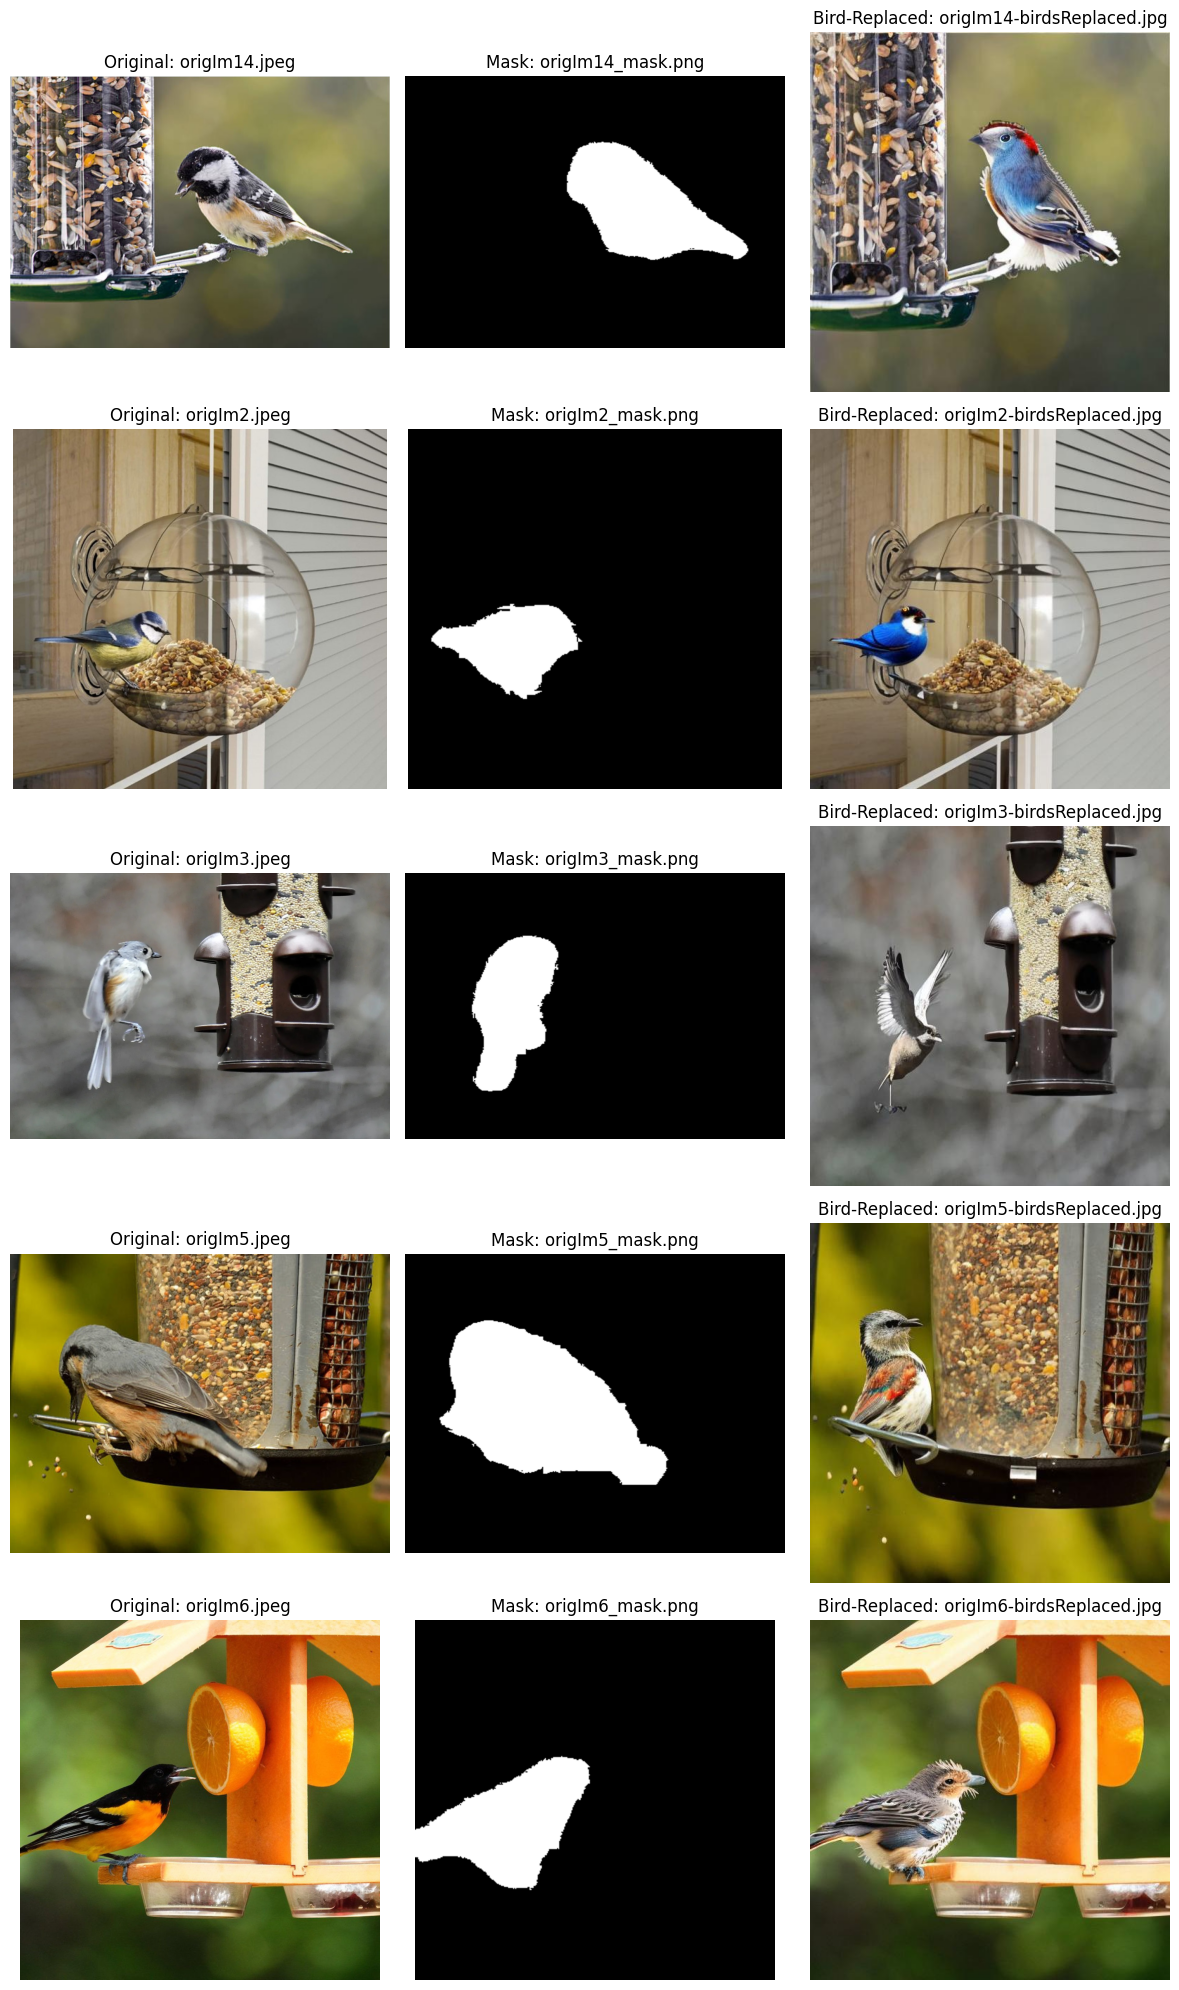

In [30]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define file names from your previous output
selected_images = [
    "images/origIm14.jpeg", "images/origIm2.jpeg", "images/origIm3.jpeg", 
    "images/origIm5.jpeg", "images/origIm6.jpeg"
]

mask_filenames = [
    "images/origIm14_mask.png", "images/origIm2_mask.png", "images/origIm3_mask.png",
    "images/origIm5_mask.png", "images/origIm6_mask.png"
]

replaced_filenames = [
    "images/origIm14-birdsReplaced.jpg", "images/origIm2-birdsReplaced.jpg", 
    "images/origIm3-birdsReplaced.jpg", "images/origIm5-birdsReplaced.jpg", 
    "images/origIm6-birdsReplaced.jpg"
]

# Ensure lists have the same number of elements
assert len(selected_images) == len(mask_filenames) == len(replaced_filenames), "Mismatch between file lists!"

# Set up the figure for visualization
fig, axes = plt.subplots(len(selected_images), 3, figsize=(12, len(selected_images) * 4))

for i, (orig_path, mask_path, replaced_path) in enumerate(zip(selected_images, mask_filenames, replaced_filenames)):
    # Load images
    orig_img = Image.open(orig_path)
    mask_img = Image.open(mask_path)
    replaced_img = Image.open(replaced_path)

    # Display original image
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"Original: {os.path.basename(orig_path)}")
    axes[i, 0].axis("off")

    # Display mask
    axes[i, 1].imshow(mask_img, cmap="gray")
    axes[i, 1].set_title(f"Mask: {os.path.basename(mask_path)}")
    axes[i, 1].axis("off")

    # Display bird-replaced image
    axes[i, 2].imshow(replaced_img)
    axes[i, 2].set_title(f"Bird-Replaced: {os.path.basename(replaced_path)}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
